<a href="https://colab.research.google.com/github/Charles-Scott-Green/Crowdfunding-revenue-prediction/blob/master/Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import libraries
import glob, os 
import pandas as pd
import json
import ast
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set()

In [0]:
import plotly.tools as tls
import plotly
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as pgo
import plotly.express as px

init_notebook_mode(connected=True)

import scipy.stats as stats

In [0]:
# functions
# Datetime data processing

def convert_to_datetime(df, column):
    """Searches dataframe for potential datetime data and ensures it is 
    formatted appropriately.  Converts objects to date time format and
    appends datetime columns to list of date time columns (erroneously
    selected columns excluded)."""
   
    try:
        df[column] = pd.to_datetime(df[column], unit = 's')
    
    except Exception:
        next
    
    return df
    
def meta_date(df, column):
    """Searches dataframe columns for column names with including word 'date' and 
    for datetime formats.  """
    
    import re
    date_splits = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
                   'Is_month_end', 'Is_month_start', 'Is_quarter_end',  
                   'Is_year_end', 'Is_year_start'] 
    
    prefix = re.sub('[Dd]ate$', '', column)
  
    for split in date_splits:
        df[prefix+'_'+split] = getattr(df[column].dt, split.lower())
    
def count_syllables(blurbs):
    """Given a string, calculates and returns the number of syllables of the word."""
    import string
    
    word_list = blurbs.translate(string.punctuation).split()
    vowels = "aeiouy"
    tally = 0
    
    for word in word_list:
        word = word.lower()
        vowels = "aeiouy"
        count = 0

        if word[0] in vowels:
            count += 1

        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                count += 1

        if word.endswith('e'):
            count -= 1

        if count == 0:
            count += 1
    
        tally += count
    
    return tally

def count_words(blurbs):
    """Returns a count of all words, less punctuation, of a given string."""
    import string

    return len(blurbs.translate(string.punctuation).split())

def count_text_attributes(df, columns):
    """Given columns to convert, returns dataframe with columns replaced with 
    new columns reflecting word and syllable counts."""
    
    new_df = df.copy()
    
    for column in columns:
        new_df[column+'_syllables'] = [count_syllables(x) for x in df[column]]
        new_df[column+'_words'] = [count_words(x) for x in df[column]]
    
    new_df = new_df.drop(columns=columns, axis=1)
    
    return new_df 
        
def confusion_matrix_stats(model, x, y):
    """Given a model, x, and y values the function returns 
    a confusion matrix table and percentage of Type I and 
    Type II errors.  Function can return a single matrix or two 
    matrices for comparing train and test sets.  
    Input for confusion matrix stats for both train and test sets
    is as follows:
     
        confusion_matrix_stats(model, [X_train, X_test], [y_train, y_test])
     
     To avoid confusion when reading matrices and error stats, order entry of 
     train and test should be observed; 'train' sets should preceed 'test' sets."""

    if len(x) > 2:
        predict = model.predict(x)
        table = pd.crosstab(y, predict, margins=True)
        tI = tabel
        print(('----- Confusion Matrix -----\n' 
               f'{table}\n' '\n' f'Accuracy:\n' 
               f'Percent Type I errors: {tI}\n' 
               f'Percent Type II errors: {tII}\n'))

    else:
        splits = ['Train set', 'Test set']
        for i,split in enumerate(x):
            predict = model.predict(split)
            table = pd.crosstab(y[i], predict, margins=True)
            tI = table.loc[0.0, 1.0] / table.loc['All', 'All']
            tII = table.loc[1.0, 0.0] / table.loc['All', 'All']

            print(('\n' f'----- {splits[i]} Confusion Matrix -----\n' 
                   f'{table}\n' '\n' 
                   f'----- {splits[i]} Accuracy -----\n' 
                   f'Percent Type I errors: {tI}\n' 
                   f'Percent Type II errors: {tII}\n'))


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/ks_data.csv'

df = pd.read_csv(path, low_memory=False)

df.head()

,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,last_update_published_at,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,unread_messages_count,unseen_activity_count,urls,usd_pledged,usd_type
0,0,1,"To create art, an artist must have their tools...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",NaN,US,NaN,1428557824,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,NaN,1429770591,False,NaN,NaN,400.0,2141932586,NaN,NaN,NaN,NaN,1428560991,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Tools of the Trade (Canceled),NaN,"{""small"":""https://ksr-ugc.imgix.net/projects/1...",20.0,"{""background_image_opacity"":0.8,""link_text_col...",tools-of-the-trade,https://www.kickstarter.com/discover/categorie...,False,False,canceled,1429332018,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",20.000000,NaN
1,1,0,"Firestarter kits for revolutionaries! markers,...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",NaN,US,NaN,1453437274,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,NaN,1455244263,False,NaN,NaN,63000.0,569937661,NaN,NaN,NaN,NaN,1453948263,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",PROJECT FLINT,NaN,"{""small"":""https://ksr-ugc.imgix.net/projects/2...",0.0,"{""background_image_opacity"":0.8,""link_text_col...",project-flint,https://www.kickstarter.com/discover/categorie...,False,False,live,1453948263,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,NaN
2,2,3,Sophie is an aspiring artist! She will be 5 in...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",NaN,US,NaN,1409805071,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,NaN,1412906207,False,NaN,NaN,1000.0,1619161443,NaN,NaN,NaN,NaN,1410314207,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",4 year old creates art for her future education.,NaN,"{""small"":""https://ksr-ugc.imgix.net/projects/1...",120.0,"{""background_image_opacity"":0.8,""link_text_col...",4-year-old-creates-art-for-her-future-education,https://www.kickstarter.com/discover/categorie...,False,False,failed,1412906207,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",120.000000,NaN
3,3,4870,Every spinning top — is built on the same beli...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",NaN,CA,NaN,1448217795,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",CAD,$,True,NaN,1453348800,False,NaN,NaN,10000.0,347223099,NaN,NaN,NaN,NaN,1450226362,"{""country"":""CA"",""urls"":{""web"":{""discover"":""htt...",ForeverSpin™ - World Famous Spinning Tops,NaN,"{""small"":""https://ksr-ugc.imgix.net/projects/2...",736320.0,"{""background_image_opacity"":0.8,""link_text_col...",foreverspintm-world-famous-spinning-tops,https://www.kickstarter.com/discover/categorie...,True,False,successful,1453348801,0.729370,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",537049.814122,NaN
4,4,0,Watch your children as they open this giant su...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",NaN,GB,NaN,1452957332,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",GBP,£,False,NaN,1455826993,False,NaN,NaN,5000.0,802476078,NaN,NaN,NaN,NaN,1453234993,"{""country"":""GB"",""urls"":{""web"":{""discover"":""htt...",Gaint surprise,NaN,"{""small"":""https://ksr-ugc.imgix.net/projects/2...",0.0,"{""background_image_opacity"":0.8,""link_text_col...",gaint-surprise,https://www.kickstarter.com/discover/categorie...,False,False,live,1453234993,1.427462,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,NaN


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338209 entries, 0 to 338208
Data columns (total 42 columns):
Unnamed: 0                  338209 non-null int64
backers_count               338209 non-null int64
blurb                       338191 non-null object
category                    338209 non-null object
converted_pledged_amount    278386 non-null float64
country                     338209 non-null object
country_displayable_name    179782 non-null object
created_at                  338209 non-null int64
creator                     338209 non-null object
currency                    338209 non-null object
currency_symbol             338209 non-null object
currency_trailing_code      338209 non-null bool
current_currency            278386 non-null object
deadline                    338209 non-null int64
disable_communication       338209 non-null bool
friends                     1337 non-null object
fx_rate                     276499 non-null float64
goal                        33

The cleaning process will require appropriately exploring each feature and appropriately preparing it for use in a model.  At first glance, a number of columns have missing data, columns with date-time data will need to be converted, several columns contain nested data, and object data will need to be explored to determine how it may be handled.

Columns of interest:

* Columns the provide no information
 * 'Unnamed: 0' is just an index.
 * 0 non-null columns:
   * 'last_update_published_at
   * 'unread_messages_count'
   * 'unseen_activity_count'
* Unique text columns that may contain useful sentiment data:
 * 'blurb'
 * 'name'
 * 'slug'
* Columns with nested data may contain more useful data.  Will need to be normalized:
 * 'category'
 * 'creator'
 * 'location'
 * 'photo'
 * 'profile'
 * 'urls'
* columns with date-time information may need to be converted to date-time
 * 'created_at'
 * 'deadline'
 * 'launched_at'
 * 'state_changed_at'
* potential target, or specific target oriented, columns to explore
 * 'state'
 * 'goal'
 * 'pledged'
 * 'usd_pledged'
 * 'converted_pledge_amount'
* columns with currency information may include redundant information.  
 * 'currency'
 * 'currency_symbol'
 * 'currency_trailing_code'
 * 'current_currency'
 * 'static_usd_rate'
 
 

In [0]:
# Drop the columns with no information
df = df.drop(columns=['Unnamed: 0', 'last_update_published_at', 'unread_messages_count',
                      'unseen_activity_count'], axis=1)

### Text Columns

The 'slug' and 'name' columns are very similar.  In fact, the 'slug' appears to match the 'name' or, in some cases, is a shortened version of the 'name'; its use is within the url.  Handling of 'slug' and 'name' data will be of similar impact.

The 'blurb' column may yield content of interest if analyzed for sentiment, complexity, or for specific words contained within the text.  These columns most likely do not require attention at this stage; they will be addressed in feature engineering.

### Nested Data

Nested data appear to contain web addresses that may be present a limit to their usefulness.  Assuming these columns are resditual json nests, they should contain similar information along their respective columns.  Before attempting to normalize, the first couple instances of each nested column will be observed to determine the next steps.

In [0]:
json.loads(df['category'][3])

{'color': 2577151,
 'id': 28,
 'name': 'Product Design',
 'parent_id': 7,
 'position': 5,
 'slug': 'design/product design',
 'urls': {'web': {'discover': 'http://www.kickstarter.com/discover/categories/design/product%20design'}}}

Categories actually appear to be sub-categories.  Cleaning may require extraction and appropriate defining of categories and sub-categories.  Either normalization or a developing a strategy to extract useful data will be performed.

<bold>Strategy</bold>
A 'parent_id' indicating a parent category is included in the data.  Additionally, an 'id' is included to designate the category.  A function could be used to extract data and create a dictionary of category, parent category, and their respective ids.  

Additionally, mapping the ids to categories and parent categories will convert the columns to numeric data that can be used in the model.

In [0]:
# keys of interest
keys = ['slug', 'name']

# Collect extracted data in lists
parent_category = []
sub_category = []

# Extract data
for i, x in enumerate(df['category']):
    nest = json.loads(df['category'][i])
    remove = nest.get(keys[1]).lower()
    
    p_cat = nest.get(keys[0]).replace('/'+remove, '')
    
    parent_category.append(p_cat)
    sub_category.append(remove)

df['parent_category'] = parent_category
df['sub_category'] = sub_category

In [0]:
json.loads(df['creator'][3])

{'avatar': {'medium': 'https://ksr-ugc.imgix.net/avatars/9098786/spinningtop2.original.jpg?v=1387850412&w=160&h=160&fit=crop&auto=format&q=92&s=2f904ef8b2a0bf371732ce8fac4d0a9a',
  'small': 'https://ksr-ugc.imgix.net/avatars/9098786/spinningtop2.original.jpg?v=1387850412&w=80&h=80&fit=crop&auto=format&q=92&s=4279a4b9a236843171dbb8f07069fb17',
  'thumb': 'https://ksr-ugc.imgix.net/avatars/9098786/spinningtop2.original.jpg?v=1387850412&w=40&h=40&fit=crop&auto=format&q=92&s=4fba06baf08f134c4cef30e5cf52a467'},
 'id': 1251371853,
 'name': 'ForeverSpin.com',
 'urls': {'api': {'user': 'https://api.kickstarter.com/v1/users/1251371853?signature=1454069387.9df172af8c30f752ec8fbede1b2536f91545392c'},
  'web': {'user': 'https://www.kickstarter.com/profile/1251371853'}}}

Web address data listed inside are of profile and avatar/image data.  The profile information within this column appears redundant.  While avatar and image analysis may be interesting, they are currently outside the scope of this experiment; normalization is unnecessary.

In [0]:
json.loads(df['location'][3])

{'country': 'CA',
 'displayable_name': 'Toronto, Canada',
 'id': 4118,
 'is_root': False,
 'name': 'Toronto',
 'short_name': 'Toronto, Canada',
 'slug': 'toronto-on-ca',
 'state': 'ON',
 'type': 'Town',
 'urls': {'api': {'nearby_projects': 'https://api.kickstarter.com/v1/discover?signature=1454065872.71501ccc743715fe29a0c2248f8a3fd4bb82b9ad&woe_id=4118'},
  'web': {'discover': 'https://www.kickstarter.com/discover/places/toronto-on-ca',
   'location': 'https://www.kickstarter.com/locations/toronto-on-ca'}}}

Location could be interesting.  While country name would be redundant, the 'name' data within creates more specificity that could be useful. A strategy for extracting the 'name', 'short_name', and/or 'id' may be useful additional location data.  On the other hand, extracting cities from countries could introduce greater dimensionality into the model.  Additionally, attempting to impute missing values for cities could introduce unnecessary bias.  This data may be revisited later.

In [0]:
json.loads(df['photo'][3])

{'1024x768': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=1024&h=768&fit=crop&auto=format&q=92&s=873c9b6269e4779d4402dfd3df90f0cb',
 '1536x1152': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=1536&h=1152&fit=crop&auto=format&q=92&s=cb053edc1f06520895b448943f8b5377',
 'ed': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=338&h=250&fit=crop&auto=format&q=92&s=0b17be831806317e6546b4f81d1216cc',
 'full': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=560&h=420&fit=crop&auto=format&q=92&s=70a49a6895caa2eab39639a83cadc2f5',
 'key': 'projects/2202666/photo-original.png',
 'little': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=200&h=150&fit=crop&auto=format&q=92&s=1fcc2e9c56d1ce047922600e387d2bd6',
 'med': 'https://ksr-ugc.imgix.net/projects/2202666/photo-original.png?v=1448218961&w=266&h=200&fit=crop&auto=format&q=92&s=b290e0e1c3a580e48

Similar to the 'creator' information, photo and image analysis might be interesting and useful.  However, these currently lie outside the scope of this experiment.

In [0]:
json.loads(df['profile'][3])

{'background_color': '',
 'background_image_opacity': 0.8,
 'blurb': 'Every spinning top — is built on the same belief:   That, above all,  a top must be absolutely simple, elegant and built forever.',
 'feature_image_attributes': {'id': 5223993,
  'image_urls': {'baseball_card': 'https://ksr-ugc.imgix.net/assets/005/223/993/ecb7b87297b5a6904b0aa291165f764e_original.png?v=1453348914&w=700&fit=max&auto=format&q=92&s=0349acee80e7831ab6aeb88485429ef6',
   'default': 'https://ksr-ugc.imgix.net/assets/005/223/993/ecb7b87297b5a6904b0aa291165f764e_original.png?v=1453348914&w=700&fit=max&auto=format&q=92&s=0349acee80e7831ab6aeb88485429ef6'}},
 'id': 2242240,
 'link_background_color': 'e68484',
 'link_text': 'Pledge on Indiegogo',
 'link_text_color': '',
 'link_url': 'http://igg.me/at/foreverspin2016',
 'name': 'ForeverSpin™ -  World Famous Spinning Tops',
 'project_id': 2242240,
 'should_show_feature_image': True,
 'show_feature_image': True,
 'state': 'active',
 'state_changed_at': 1453349046

Contains redundant data.  

In [0]:
json.loads(df['urls'][3])

{'web': {'project': 'https://www.kickstarter.com/projects/1251371853/foreverspintm-world-famous-spinning-tops?ref=category',
  'rewards': 'https://www.kickstarter.com/projects/1251371853/foreverspintm-world-famous-spinning-tops/rewards'}}

Web address data is historical in nature, but is not viewable.  No useful information is able to be extracted. 

### Dates



In [0]:
# Convert unix timestamps to dates
date_columns = ['created_at', 'deadline', 'launched_at', 'state_changed_at']

for column in date_columns: 
    convert_to_datetime(df, column)

In [0]:
df[['created_at', 'launched_at', 'deadline']].describe()

,created_at,launched_at,deadline
count,338209,338209,338209
unique,337947,337780,311838
top,2015-01-20 21:14:16,2018-02-01 22:34:51,2018-07-04 03:59:00
freq,2,3,55
first,2009-04-21 17:35:35,2009-04-24 19:52:03,2009-05-03 06:59:59
last,2019-10-16 22:53:47,2019-10-17 05:25:04,2019-12-16 06:25:04


### Potential Target/Target related data


In [0]:
# Description of specified data
df[['state', 'goal', 'pledged', 'usd_pledged', 'converted_pledged_amount']].describe()

,goal,pledged,usd_pledged,converted_pledged_amount
count,3.382090e+05,3.382090e+05,3.382090e+05,2.783860e+05
mean,4.639210e+04,1.584884e+04,1.224693e+04,1.242938e+04
std,1.083817e+06,2.928815e+05,1.090064e+05,9.494720e+04
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+03,6.000000e+01,5.711489e+01,8.100000e+01
50%,5.000000e+03,1.033750e+03,1.014682e+03,1.259000e+03
75%,1.500000e+04,5.555990e+03,5.385000e+03,5.909000e+03
max,1.000000e+08,9.886382e+07,2.033899e+07,1.214344e+07


In [0]:
# 'state' is an object; likley categorical
print(df['state'].value_counts())
df['state'].describe()

successful    152698
failed        132326
live           35060
canceled       17056
suspended       1069
Name: state, dtype: int64


count         338209
unique             5
top       successful
freq          152698
Name: state, dtype: object

A point of interest is that successful campaigns outnumber failed campaigns.  Another point to consider, however, is that canceled and suspended campaigns might be viewed failed, but more information regarding definitions of categories might be needed before making a final determination.  

Additionally, a numer of live campaigns may have very interesting data as well.  This information may help establish a strategy.  If data will be treated as a time series, live campaigns could be considered for separation as a test set.  However, the ability to evaluate live campaigns final outcomes would be difficult.

Values of 'goal', 'pledged', 'usd_pledged', and 'converted_pledged_amount' show that values vary over a wide range and, given standard deviations larger than the mean, are likely to present very skewed distributions with long right tails.  Another important note is consideration of the units used in the columns.  The 'pledged' column appears to have two transformations.  The existence of currency features indicates the units are not the same and must be standardized.  

At this time, further cleaning is not necessary.  None of the columns are missing data.  Each will be evaluated further during EDA and Feature Engineering steps.

### Currency Information

In [0]:
df[['currency', 'currency_symbol', 'currency_trailing_code', 
    'current_currency', 'static_usd_rate', 'fx_rate']].describe()

,static_usd_rate,fx_rate
count,338209.000000,276499.000000
mean,1.009954,1.012364
std,0.220080,1.547712
min,0.008771,0.007127
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.716408,149.438696


In [0]:
df['static_usd_rate'][100000:100025], df['fx_rate'][100000:100025]

(100000    1.000000
 100001    1.000000
 100002    1.000000
 100003    1.000000
 100004    1.000000
 100005    1.000000
 100006    1.000000
 100007    1.000000
 100008    1.087572
 100009    1.000000
 100010    1.000000
 100011    1.000000
 100012    1.000000
 100013    1.000000
 100014    1.000000
 100015    1.000000
 100016    1.000000
 100017    1.126563
 100018    1.000000
 100019    1.000000
 100020    1.000000
 100021    1.000000
 100022    1.000000
 100023    1.000000
 100024    1.000000
 Name: static_usd_rate, dtype: float64, 100000    1.000000
 100001    1.000000
 100002    1.000000
 100003    1.000000
 100004    1.000000
 100005    1.000000
 100006    1.000000
 100007    1.000000
 100008    1.132671
 100009    1.000000
 100010    1.000000
 100011    1.000000
 100012    1.000000
 100013    1.000000
 100014    1.000000
 100015    1.000000
 100016    1.000000
 100017    1.136508
 100018    1.000000
 100019    1.000000
 100020    1.000000
 100021    1.000000
 100022    1.000000
 

In [0]:
df[['currency', 'currency_symbol', 'currency_trailing_code', 
    'current_currency']].describe()

,currency,currency_symbol,currency_trailing_code,current_currency
count,338209,338209,338209,278386
unique,14,6,2,11
top,USD,$,True,USD
freq,248070,277851,281948,276865


In [0]:
df['currency'].value_counts()

USD    248070
GBP     33278
EUR     21519
CAD     14598
AUD      7680
MXN      3367
SEK      2065
HKD      1586
NZD      1443
DKK      1276
SGD      1107
CHF       986
NOK       756
JPY       478
Name: currency, dtype: int64

The 'static_usd_rate' column appears the be a conversion rate of currency types to the US dollar.  As it is missing no values, this is a very useful feature for standaridzation of units.  

The 'fx_rate' column appears to be a foreign exchange rate.  While this may be useful, the column includes a number of missing values that will need handling.  If standardizing the goal and pledge amounts to the US dollar, this feature may not be necessary.

The 'currency', 'currency_symbol', 'currency_trailing_code' and 'current_currency' columns are categorical.  The currency_trailing_code is likely to be disregarded in this experiment.  Of note is the differences in unique categories between 'currency', 'currency_symbol', and 'current_currency'; the expectation would be that the number of unique categories would be equal.

Finally, observing that USD is the most numerous (over 80% of all observations), the currency units will be standardized according the the USD.  This will remove location information associated with currency, however, this information is available elsewhere in the data.

## Business Case

There are two potential targets to be considered based upon the potential questions to ask:
* Will a kickstarter campaign succeed?  (Target is 'state')
* Can we predict the potential funds of a kickstarter campaign? (Target is 'goal')

In one instance, the question is a classification problem.  In the other, the question is a regression problem.  Which way to go?  

<h3><center>Acme Crowd Funder Services</center></h3>

Let's imagine that we are a marketing startup with a very specific niche:  Crowdfunding Campaign Design.  

Our clients are interested in using crowdfunding to support their projects.  Given their limited capital, organizing a successful campaign is vital to their project; and, perhaps, of vital importance to gaining a competitive edge for their new idea.    

If we wish to establish the viability of a Crowdfunding Design niche, and more, ourselves as the Crowdfunding Design leaders, we need to develop a successful track record.  If our fee schedule is commission based, or a combination of expense plus commission, we are further motivated; not only to succeed, but to exceed the minimum success goals.

That said, treating this question as a regression problem is most appropriate.  This experiment will attempt to create a model that can predict pledge Kickstarter campaign pledge amounts.  The added benefit of this approach is that the presence of the 'goal' data allows for determining if success will be achieved. 

In [0]:
df.describe()

,backers_count,converted_pledged_amount,fx_rate,goal,id,pledged,static_usd_rate,usd_pledged
count,338209.000000,2.783860e+05,276499.000000,3.382090e+05,3.382090e+05,3.382090e+05,338209.000000,3.382090e+05
mean,142.027663,1.242938e+04,1.012364,4.639210e+04,1.074441e+09,1.584884e+04,1.009954,1.224693e+04
std,1042.564137,9.494720e+04,1.547712,1.083817e+06,6.193089e+08,2.928815e+05,0.220080,1.090064e+05
min,0.000000,0.000000e+00,0.007127,1.000000e-02,8.624000e+03,0.000000e+00,0.008771,0.000000e+00
25%,3.000000,8.100000e+01,1.000000,2.000000e+03,5.370275e+08,6.000000e+01,1.000000,5.711489e+01
50%,19.000000,1.259000e+03,1.000000,5.000000e+03,1.076300e+09,1.033750e+03,1.000000,1.014682e+03
75%,75.000000,5.909000e+03,1.000000,1.500000e+04,1.609656e+09,5.555990e+03,1.000000,5.385000e+03
max,219382.000000,1.214344e+07,149.438696,1.000000e+08,2.147476e+09,9.886382e+07,1.716408,2.033899e+07


In [0]:
df.describe(include='O')

,blurb,category,country,country_displayable_name,creator,currency,currency_symbol,current_currency,friends,is_backing,is_starrable,is_starred,location,name,permissions,photo,profile,slug,source_url,state,urls,usd_type,parent_category,sub_category
count,338191,338209,338209,179782,338209,338209,338209,278386,1337,1337,289507,1337,337137,338206,1217,338209,338209,338209,321864,338209,338209,276865,338209,338209
unique,334577,304,22,22,337363,14,6,11,3,2,2,2,62413,336268,1,338191,338209,338209,279,5,338209,2,15,160
top,Help support the largest creative collaboratio...,"{""id"":34,""name"":""Tabletop Games"",""slug"":""games...",US,the United States,"{""id"":978911160,""name"":""For Freedoms"",""is_regi...",USD,$,USD,[],False,False,False,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Debut Album,[],"{""key"":null,""full"":""https://ksr-ugc.imgix.net/...","{""id"":396000,""project_id"":396000,""state"":""inac...",pollocks-first-full-length-album,https://www.kickstarter.com/discover/categorie...,successful,"{""web"":{""project"":""https://www.kickstarter.com...",domestic,film & video,product design
freq,52,10073,248070,126720,12,248070,277851,276865,1335,1333,265886,1328,8057,11,1217,14,1,1,8557,152698,1,191219,46638,18953


### Handling Missing Data

Given the number of null values, it makes sense to address them first.  This may help establish a baseline for evaluating the data per column in the dataset.

In [0]:
# Define nulls and drop any column in exceeding 15% volume of the overall data
nulls = df.isnull().sum()
null_percent = nulls[nulls>0] / df.shape[0]
drop_columns = null_percent[null_percent > 0.15]

df = df.drop(columns=drop_columns.index, axis=1)

In [0]:
# Check remaining nulls
nulls = df.isnull().sum()
null_percent = nulls[nulls>0] / df.shape[0]

null_percent

blurb           0.000053
is_starrable    0.144000
location        0.003170
name            0.000009
source_url      0.048328
dtype: float64

Before dropping additional columns, let's look at potential relationships between our data and target.  While the 'state' column is not the intended target goal, it establishes a good baseline for potential correlation.

In [0]:
cat_columns = ['country', 'sub_category', 'is_starrable', 'parent_category']

for column in cat_columns:
    cont_table = pd.crosstab(index=df['state'], columns=df[column])
    chi2, pval, _, _ = stats.chi2_contingency(cont_table)
    print(f'Chi-squared test statistic for {column}: {chi2}')
    print(f'p-value: {pval}')

Chi-squared test statistic for country: 8870.020427373853
p-value: 0.0
Chi-squared test statistic for sub_category: 163779.8800573402
p-value: 0.0
Chi-squared test statistic for is_starrable: 268843.5674748833
p-value: 0.0
Chi-squared test statistic for parent_category: 54462.50614207457
p-value: 0.0


The $\chi^2$ tests indicate rejection of the null hypothesis that 'state' is independent of the 'country', 'category', 'is_starrable' and 'parent_category' columns.  The column of note, the 'is_starrable' column, will require a bit more exploration to determine how to impute null values.  

One explanation for the missing values would be the evolution of the crowdfunding platform.  The 'is_starrable' column may represent an added feature that was previously unavailable and, therefore, unrecorded.  In a strictly literal sense, missing values would indicate either undesignated or metric unavailable and therefore imputing False would be accurate.  


In [0]:
# Fill missing data with False
df['is_starrable'] = df['is_starrable'].fillna(False)

# Check remaining nulls
nulls = df.isnull().sum()
null_percent = nulls[nulls>0] / df.shape[0]

null_percent

blurb         0.000053
location      0.003170
name          0.000009
source_url    0.048328
dtype: float64

In [0]:
# Dropping remaining null values by row will have minimal affect on data loss
df = df.dropna()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320807 entries, 0 to 338208
Data columns (total 31 columns):
backers_count             320807 non-null int64
blurb                     320807 non-null object
category                  320807 non-null object
country                   320807 non-null object
created_at                320807 non-null datetime64[ns]
creator                   320807 non-null object
currency                  320807 non-null object
currency_symbol           320807 non-null object
currency_trailing_code    320807 non-null bool
deadline                  320807 non-null datetime64[ns]
disable_communication     320807 non-null bool
goal                      320807 non-null float64
id                        320807 non-null int64
is_starrable              320807 non-null bool
launched_at               320807 non-null datetime64[ns]
location                  320807 non-null object
name                      320807 non-null object
photo                     320807 non-nu

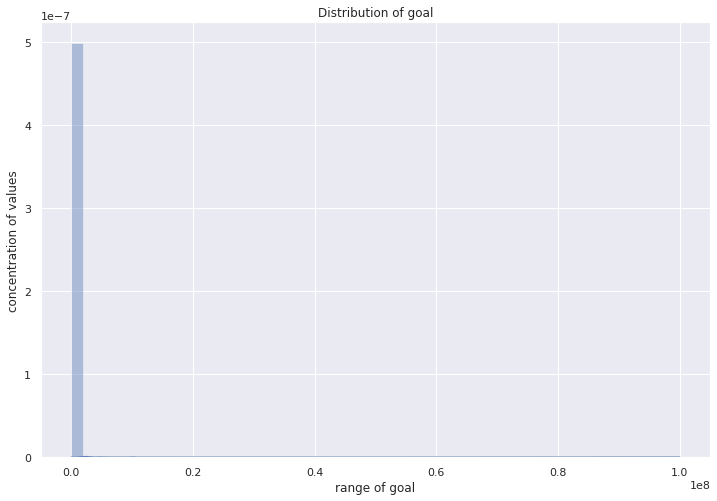

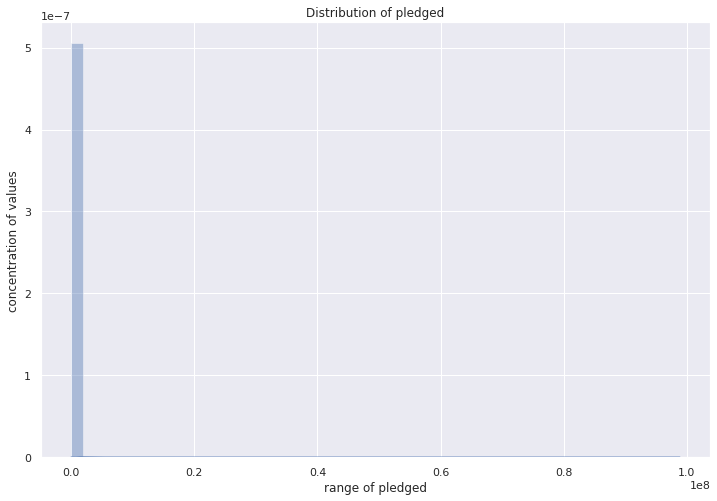

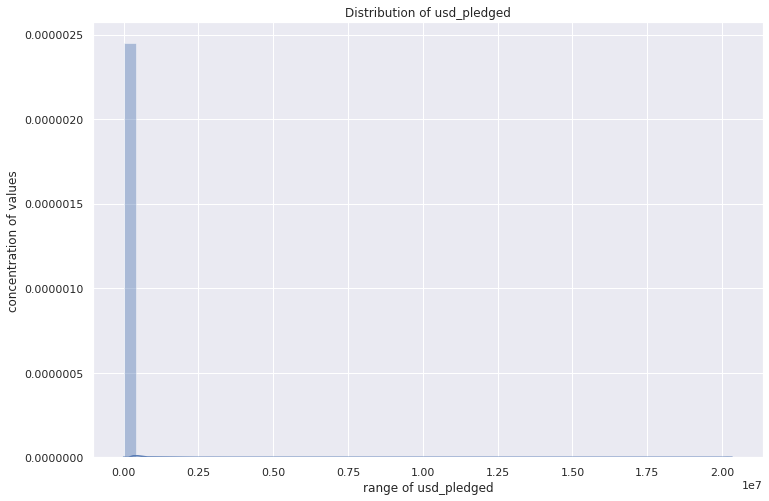

In [0]:
gr_cols = ['goal', 'pledged', 'usd_pledged']

for col in gr_cols:
    plt.figure(figsize=(12,8))
    sns.distplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'range of {col}')
    plt.ylabel('concentration of values')
    plt.show()


Each plot shows extreme outlier data causing high amount of skew and kurtosis.  Given the extremeness of outlier data and a high concentration of data near zero, normalization may prove difficult.  Neither Acme Crowd Funder Services nor their clients are interested in campaigns generating zero dollars pledged.  It may make sense to remove observations of zero dollars pledged.  

In [0]:
# create column with all goals converted to usd
df['usd_goal'] = df['goal'] * df['static_usd_rate']

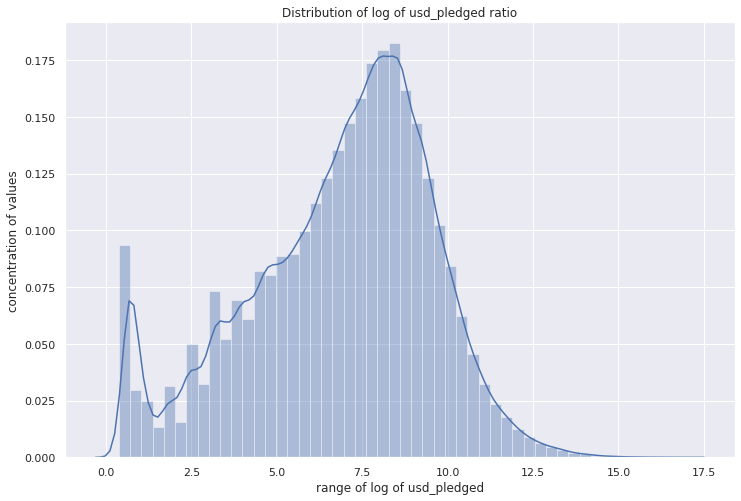

In [0]:
plg = df['usd_pledged'][(df['usd_pledged']!=0)]

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(plg))
plt.title('Distribution of log of usd_pledged ratio')
plt.xlabel('range of log of usd_pledged')
plt.ylabel('concentration of values')

plt.show()

While not perfect, this distribution does approach normal and will be useful.  Before dropping data, however, additional analysis will be performed.

In [0]:
# Look at features correlated with the target 
corr_w_target = (abs(df.corr()))['usd_pledged'].sort_values(ascending = False)[1:]
corr_w_target

backers_count             0.753669
pledged                   0.386311
staff_pick                0.130384
spotlight                 0.104765
is_starrable              0.020301
currency_trailing_code    0.008914
goal                      0.008832
usd_goal                  0.006988
disable_communication     0.003267
id                        0.001234
static_usd_rate           0.000844
Name: usd_pledged, dtype: float64

Interestingly, the 'backers_count' feature is more positively correlated with the target than the pre-transformed target.  The 'pledged' cannot be used because it is the pre-transformed target value and will overly bias the model.  The 'backers_count' and 'goal' columns are numeric that are positively correlated with the target.  Another positively correlated feature that might be interesting is the 'static_usd_rate'.  Given fluxuations of the value of the dollar, this feature may establish potential economic influence impacting crowd funding.  Other features seen as correlated are either categorical, boolean, or marked for removal.  



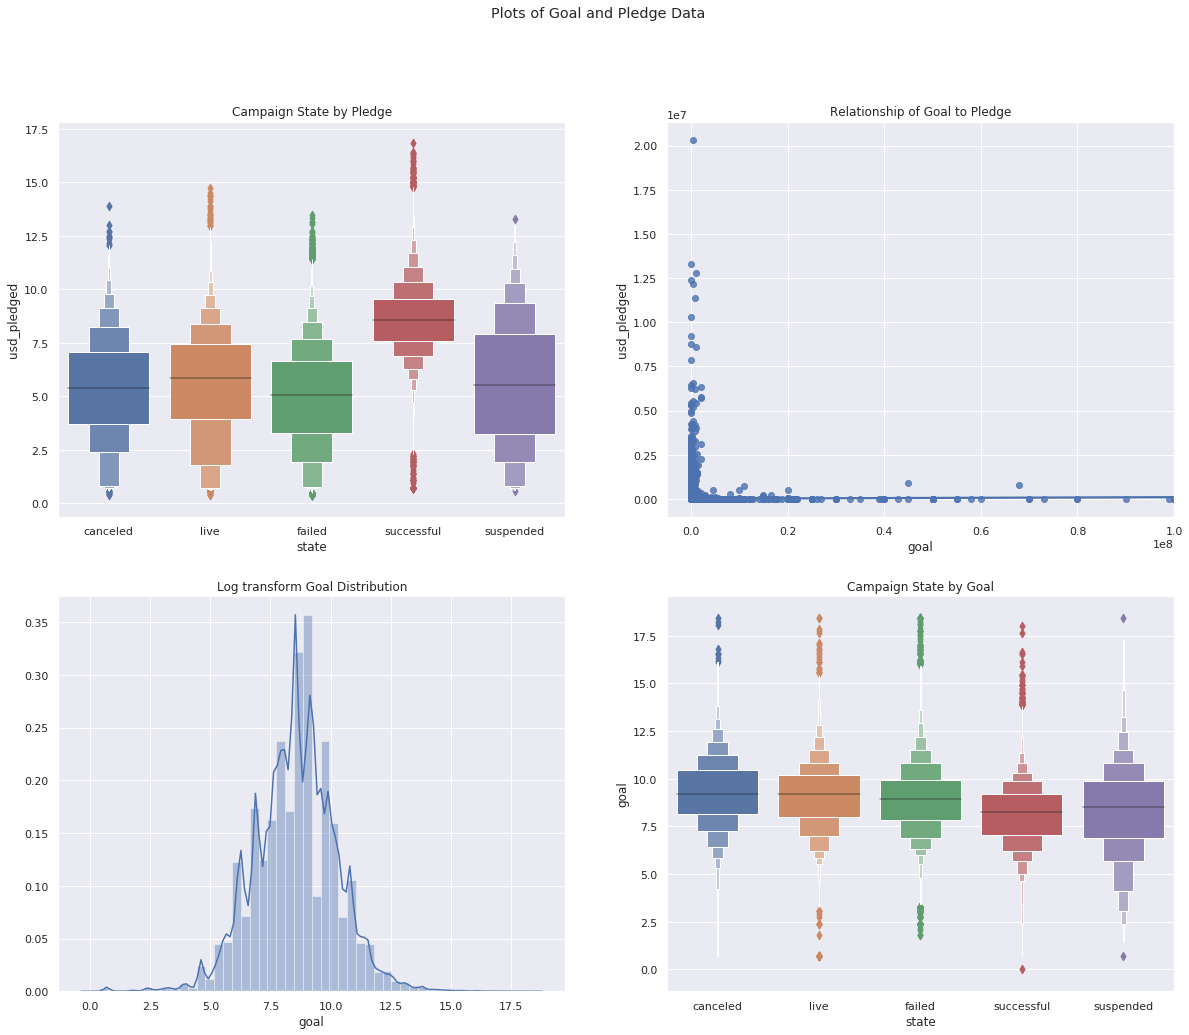

In [0]:
# Temporarily remove zero pledge values 
goals = df['goal'][df['usd_pledged']>1]
pledges = df['usd_pledged'][df['usd_pledged']>1]

# Plot data
plt.figure(figsize=(20, 16))
plt.suptitle('Plots of Goal and Pledge Data')
plt.subplot(2,2,1)
plt.title('Campaign State by Pledge')
sns.boxenplot(df['state'], np.log1p(df['usd_pledged'][df['usd_pledged']!=0]))

plt.subplot(2,2,2)
plt.title('Relationship of Goal to Pledge')
sns.regplot(df['goal'], df['usd_pledged'])

plt.subplot(2,2,3)
plt.title('Log transform Goal Distribution')
sns.distplot(np.log1p(goals))

plt.subplot(2,2,4)
plt.title('Campaign State by Goal')
sns.boxenplot(df['state'], np.log1p(df['goal'][df['usd_pledged']!=0]))

plt.show()

When looking at the boxen plots of campaign states and pledge amounts, it makes sense that successful campaigns have higher averages than failed.  Based on the plot, the pledge amounts for successful campaigns appear well distributed and form a close approximation to normal.  

For live and failed campaigns, a negative skew exists, but according to statistical calculations, they could be treated as normal distributions.  Whereas outliers for successful campaigns appear to have a canceling affect on the mean, the average pledge amounts of live and failed campaigns appear to be pulled upward by outliers.  

Another interesting insight is that live campaigns are the second highest average pledge amound.  When compared to the boxen plot of campaign goals, live campaigns also have the second highest average goal.  From a chronological perspective, these insights may indicate that, as time goes by, project planning has improved; leading to more ambitious, and potentially attainable, goals.

While successful campaigns have the highest average pledge amount, they have the lowest goal amounts.  These averages, however, appear in agreement.  Additionally, outliers for successful campaign goals tend to be lower than goals of other campaign states.  This information may indicate successful campaigns are strategically planned with realistic, attainable goals (good news for Acme Crowd Funder Services).  

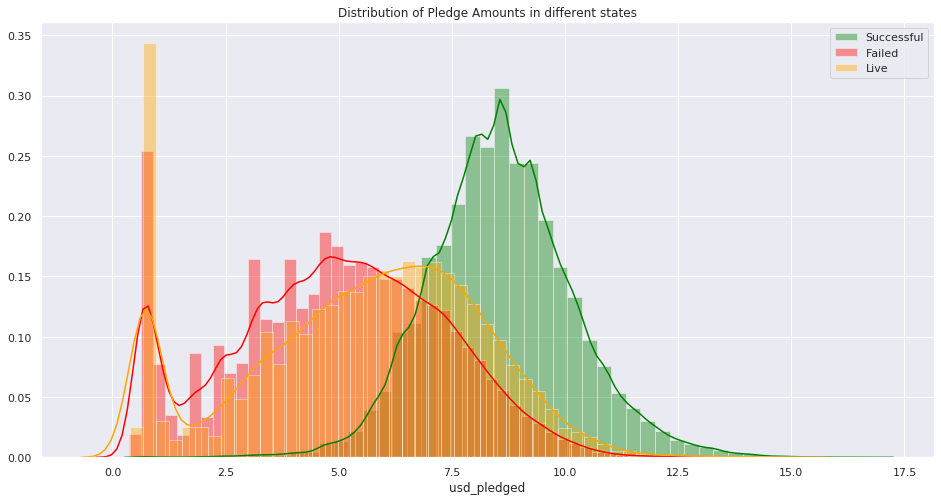

DescribeResult(nobs=146236, minmax=(0.6931471805599453, 16.82805015727629), mean=8.580533212810773, variance=2.4919604487212315, skewness=0.16017313686946655, kurtosis=0.821236599352452)
DescribeResult(nobs=103108, minmax=(0.3759362580847145, 13.488446370534637), mean=4.971468854503473, variance=5.465586857262396, skewness=-0.05227904535746348, kurtosis=-0.5714235783120221)
DescribeResult(nobs=27512, minmax=(0.3860634404169376, 14.71821014726643), mean=5.538851221942933, variance=6.742398528538294, skewness=-0.29260918505229566, kurtosis=-0.5156946478708817)


In [0]:
plt.figure(figsize=(16,8))
plt.title('Distribution of Pledge Amounts in different states')
sns.distplot(np.log1p(df['usd_pledged'][(df['state']=='successful')]), color='green', label='Successful')
sns.distplot(np.log1p(df['usd_pledged'][(df['state']=='failed') & (df['usd_pledged']!=0)]), 
             color='red', label='Failed')
sns.distplot(np.log1p(df['usd_pledged'][(df['state']=='live') & (df['usd_pledged']!=0)]), 
             color='orange', label='Live')
plt.legend()

plt.show()

print(stats.describe(np.log1p(df['usd_pledged'][(df['state']=='successful')])))
print(stats.describe(np.log1p(df['usd_pledged'][(df['state']=='failed') & (df['usd_pledged']!=0)])))
print(stats.describe(np.log1p(df['usd_pledged'][(df['state']=='live') & (df['usd_pledged']!=0)])))

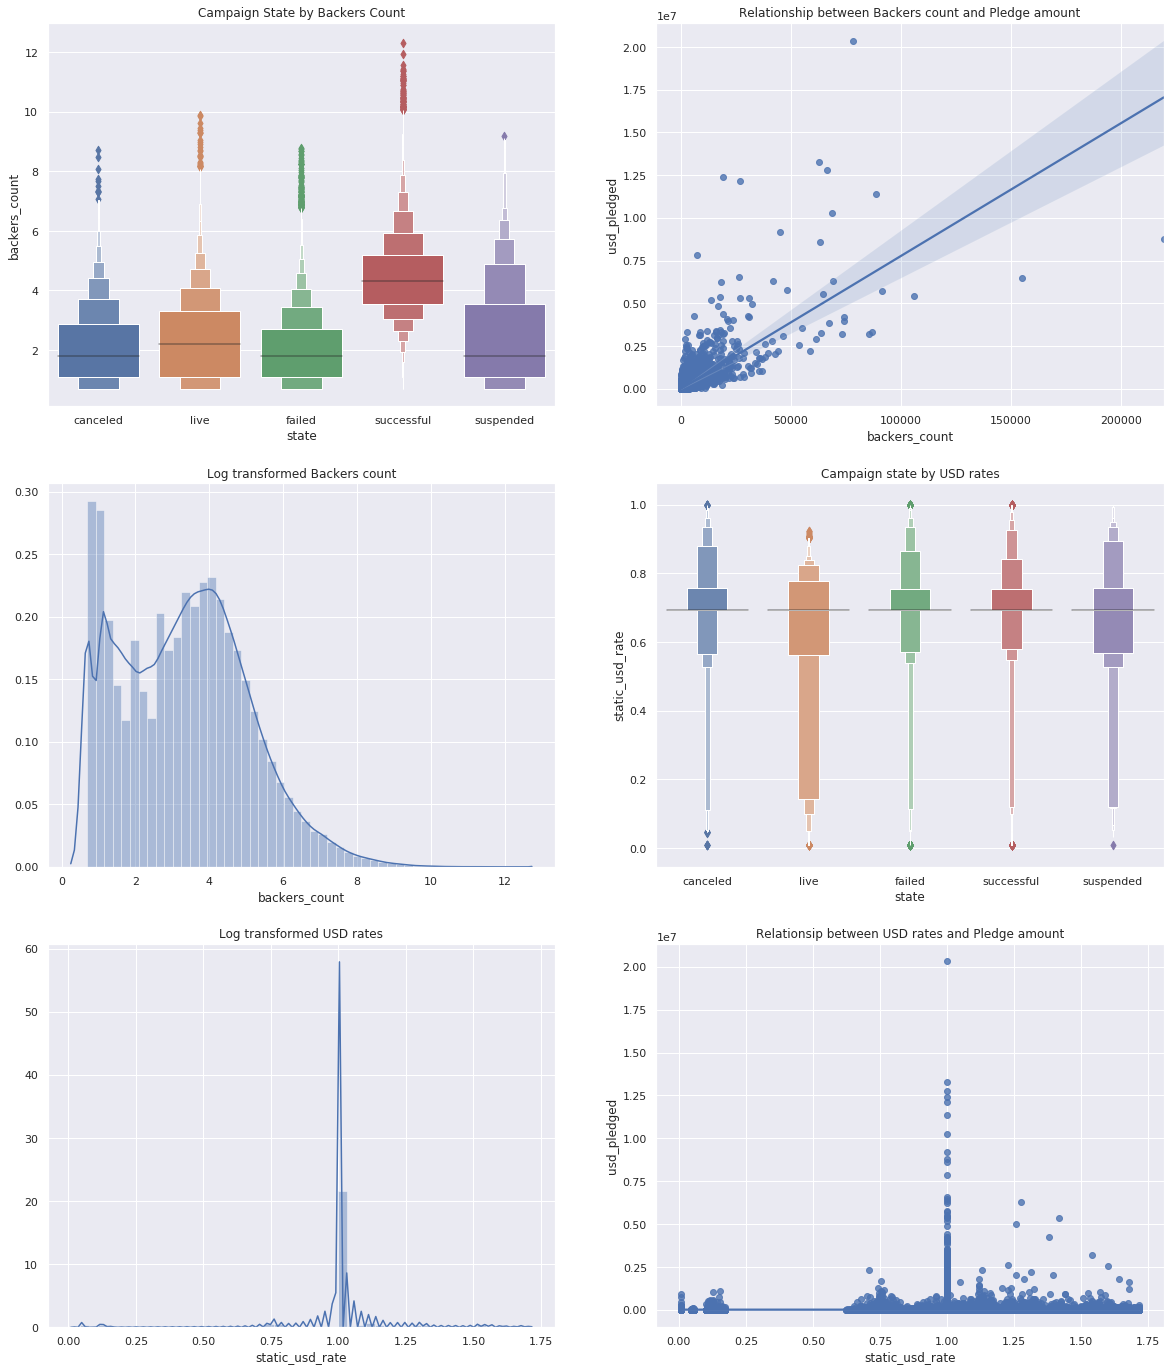

In [0]:
# Temporarily remove zero pledge amounts for plotting
backs = df['backers_count'][df['usd_pledged']>1]
rates = df['static_usd_rate'][df['usd_pledged']>1]
pledges = df['usd_pledged'][df['usd_pledged']>1]

# Plot data
plt.figure(figsize=(20, 24))
plt.subplot(3,2,1)
plt.title('Campaign State by Backers Count')
sns.boxenplot(df['state'], np.log1p(df['backers_count'][df['usd_pledged']!=0]))

plt.subplot(3,2,2)
plt.title('Relationship between Backers count and Pledge amount')
sns.regplot(df['backers_count'], df['usd_pledged'])

plt.subplot(3,2,3)
plt.title('Log transformed Backers count')
sns.distplot(np.log1p(backs))

plt.subplot(3,2,4)
plt.title('Campaign state by USD rates')
sns.boxenplot(df['state'], np.log1p(df['static_usd_rate'][df['usd_pledged']!=0]))

plt.subplot(3,2,5)
plt.title('Log transformed USD rates')
sns.distplot(df['static_usd_rate'])

plt.subplot(3,2,6)
plt.title('Relationsip between USD rates and Pledge amount')
sns.regplot(df['static_usd_rate'], df['usd_pledged'])

plt.show()

An immediate insight:  <strong>Backers are a strong indicator of success.</strong>

This seems as though it would be a hindsight statistic, however, information exists within the data that implies that knowledge of potential backers is not necessarily ex post facto.  
* 'created_at' - Defines the date the campaign is registered with Kickstarter.  This does not indicate a live campaign, rather it is a delcaration of the intent to launch a campaign.
* 'launched_at' - Defines the date the campaign is live and accepting pledges.  

Domain research confirms that once a campaign is created, a preview link is provided.  While the campaign is not live, a link to the preview page may be provided to potential backers.  Hence, a reasonable estimation of backers may be attainable.  While developing and executing a marketing strategy may occur before campaign creation, the amount of time between creation and launch is measureable; and may provide useful information.

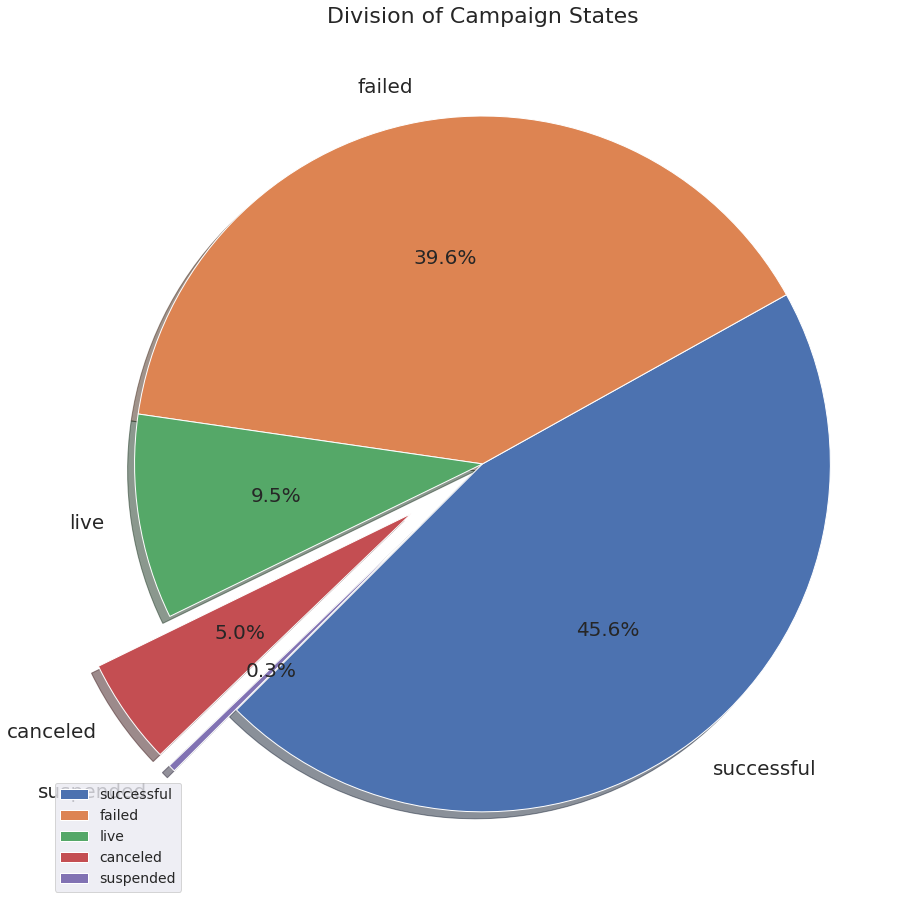

In [0]:
# Plot a pie chart to demonstrate divisions of campaign states
explode = (0, 0, 0, 0.25, 0.25)

plt.figure(figsize=(20, 16))
plt.title('Division of Campaign States', fontsize=22)
plt.pie(df['state'].value_counts(), labels=df['state'].value_counts().index, 
        explode=explode, startangle=225, shadow=True, autopct='%1.1f%%', 
        textprops={'fontsize': 20})

plt.legend(fontsize=14)
plt.show()

Canceled and suspended campaigns may offer information pertaining to the target data, however, lacking definition and/or causes for cancelation and suspension, information included in these columns could introduce noise and bias into the model.  For this reason, these categories will be disregarded.  

Live campaigns, on the other hand, are interesting; especially given earlier insights.  Additionally, the model is targeting plegde dollars instead of success or failure.  This allows for live campaign data to be useful. 


## Feature Engineering

### Trimming

While some noisy features, data, and incomplet obserations have already been removed, analysis indicates others may not be helpful to building a model.  At this point, redundant columns and rows/columns identified as potential noise, or not useful, may be removed.

In [0]:
cols_to_drop = ['creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'disable_communication',
                'id', 'location', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'state_changed_at', 
                'urls', 'category']

# Drop columns marked for removal
df = df.drop(columns=cols_to_drop, axis=1)

# Trim data frame to include only successful, live, and failed campaigns
df = df[(df['state']=='failed') | (df['state']=='successful') | (df['state']=='live')]

# Trim data frame to include only 'usd_pledged' amounts greater than zero
df = df[df['usd_pledged']!=0]



### Date-time data

Information within dates can be very powerful.  This metadata can include information like, day-of-the-week, week-of-the-year, fiscal information, and time change information.  This will be extracted and calculated. 

In [0]:
# Feature Engineering
# Convert unix timestamps to dates
date_columns = ['created_at', 'deadline', 'launched_at']

for column in date_columns: 
    meta_date(df, column)
    
df['created_to_launch_elapsed'] = (df['launched_at'] - df['created_at']).dt.days
df['created_to_deadline_elapsed'] = (df['deadline'] - df['created_at']).dt.days
df['launch_to_deadline_elapsed'] = (df['deadline'] - df['launched_at']).dt.days

df = df.drop(columns=date_columns, axis=1)

### Text Data  

Text data may hold several nuggets of information; especially when it comes to sentiment.  While sentiment will not be explored at this time, other attributes of text will be evaluated:
* word count
* syllable count

From a marketing perspective, the goal would be to convey a message concisely.  This premise may indicate that word counts and syllable counts may serve as basic evaluation of message complexity.  

In [0]:
df2 = df.copy()

In [0]:
df2 = count_text_attributes(df2, ['blurb', 'name'])

In [0]:
df2 = pd.concat([df2, pd.get_dummies(df2['parent_category'], prefix='pcat', drop_first=True)], 
                axis=1)

In [0]:
df2 = pd.concat([df2, pd.get_dummies(df2['sub_category'], prefix='subcat', drop_first=True)], 
                axis=1)  

In [0]:
df2.head()

,backers_count,country,goal,is_starrable,spotlight,staff_pick,state,static_usd_rate,usd_pledged,parent_category,sub_category,usd_goal,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_year_end,created_at_Is_year_start,deadline_Year,deadline_Month,...,subcat_spaces,subcat_stationery,subcat_tabletop games,subcat_taxidermy,subcat_technology,subcat_television,subcat_textiles,subcat_theater,subcat_thrillers,subcat_translations,subcat_typography,subcat_vegan,subcat_video,subcat_video art,subcat_video games,subcat_wearables,subcat_weaving,subcat_web,subcat_webcomics,subcat_webseries,subcat_woodworking,subcat_workshops,subcat_world music,subcat_young adult,subcat_zines
2,3,US,1000.0,False,False,False,failed,1.00000,120.000000,art,painting,1000.0000,2014,9,36,4,3,247,False,False,False,False,False,2014,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4870,CA,10000.0,False,True,False,successful,0.72937,537049.814122,design,product design,7293.7013,2015,11,47,22,6,326,False,False,False,False,False,2016,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,23,US,40000.0,False,False,False,live,1.00000,2180.000000,design,product design,40000.0000,2015,7,29,19,6,200,False,False,False,False,False,2016,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2,US,150000.0,False,False,False,live,1.00000,31.000000,design,product design,150000.0000,2016,1,53,3,6,3,False,False,False,False,False,2016,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2,US,38000.0,False,False,False,live,1.00000,16.000000,design,product design,38000.0000,2016,1,3,19,1,19,False,False,False,False,False,2016,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df2 = pd.concat([df2, pd.get_dummies(df2['country'], drop_first=True)], 
                axis=1)

In [0]:
df2.head()

,backers_count,country,goal,is_starrable,spotlight,staff_pick,state,static_usd_rate,usd_pledged,parent_category,sub_category,usd_goal,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_year_end,created_at_Is_year_start,deadline_Year,deadline_Month,...,subcat_workshops,subcat_world music,subcat_young adult,subcat_zines,AU,BE,CA,CH,DE,DK,ES,FR,GB,HK,IE,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
2,3,US,1000.0,False,False,False,failed,1.00000,120.000000,art,painting,1000.0000,2014,9,36,4,3,247,False,False,False,False,False,2014,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4870,CA,10000.0,False,True,False,successful,0.72937,537049.814122,design,product design,7293.7013,2015,11,47,22,6,326,False,False,False,False,False,2016,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,23,US,40000.0,False,False,False,live,1.00000,2180.000000,design,product design,40000.0000,2015,7,29,19,6,200,False,False,False,False,False,2016,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,2,US,150000.0,False,False,False,live,1.00000,31.000000,design,product design,150000.0000,2016,1,53,3,6,3,False,False,False,False,False,2016,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,2,US,38000.0,False,False,False,live,1.00000,16.000000,design,product design,38000.0000,2016,1,3,19,1,19,False,False,False,False,False,2016,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
df2 = df2.drop(columns=['country', 'parent_category', 'sub_category', 'goal'], axis=1)

In [0]:
# save clean version of data
path2 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data.csv'
df2.to_csv(path2)

Data is prepared to feed into a model.  

<strong>Note: </strong>
Data has not been evaluated for feature selection.  EDA will be performed in another notebook linked below.

https://colab.research.google.com/drive/1kojVItujzt14Vdjp9VLJJYe_Z9EzvGYf
